This notebook was used to analyze the output from the notebook "DRG histology segmentation". It's a bit messier since there's more exploration on what the best way to present/analyze the output from the image segmentation is.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
from pathlib import Path
from scipy import stats
from statannot import add_stat_annotation
import itertools

df_master = pd.read_pickle("path-to-folder/summary_dataframe.pkl")

<AxesSubplot:xlabel='area', ylabel='Count'>

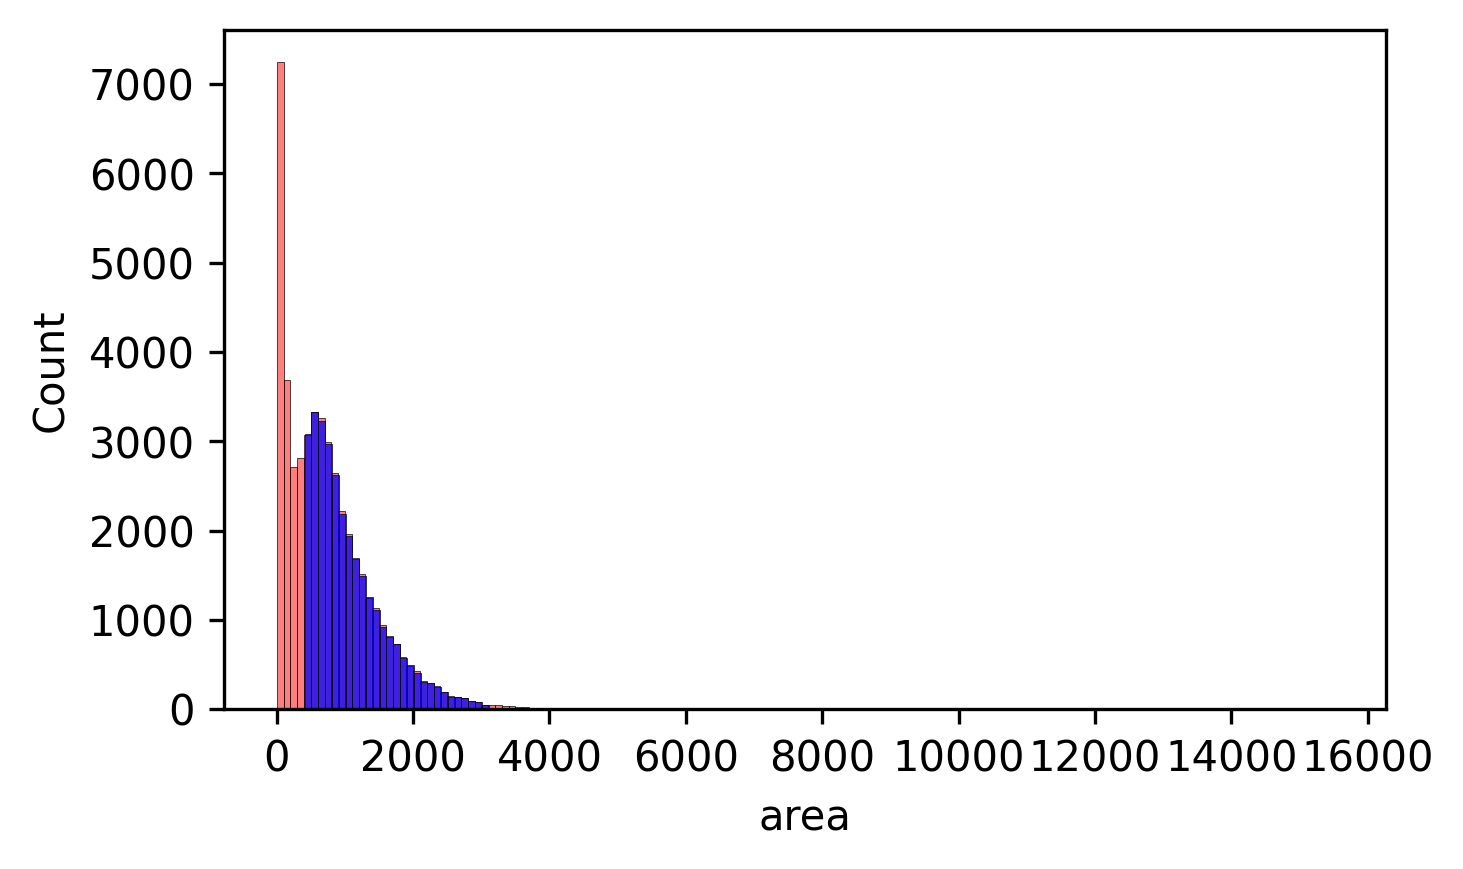

In [2]:
# make a copy of the data
df_filter = df_master.copy()

"""
filter segmentation masks by size.
very small masks are poorly segmented cells
very large masks are multiple cells/debris
"""

fig, ax = plt.subplots(figsize=(5,3), dpi=300)
# plot all segmentation masks
sns.histplot(data=df_master, x='area', color = 'r', ax=ax, alpha=0.5, binwidth=100)
cutoff_low = np.percentile(df_master['area'], 35)
cutoff_high = np.percentile(df_master['area'], 99)

df_filter = df_filter.loc[(df_filter['area'] > cutoff_low) & 
                          (df_filter['area'] < cutoff_high)]
# plot selected masks
sns.histplot(data = df_filter, x='area', color = 'b', ax=ax, binwidth=100)


In [ ]:
# filter masks by solidity. DRGs have high solidity.

df_filter = df_master.copy()
fig, ax = plt.subplots(figsize=(5,3), dpi=300)
sns.histplot(data=df_master, x='solidity', color = 'r', ax=ax, alpha=0.5, binwidth=0.01)
cutoff = np.percentile(df_master['solidity'], 10)

df_filter = df_filter.loc[(df_filter['solidity'] > cutoff)]
sns.histplot(data = df_filter, x='solidity', color = 'b', ax=ax, binwidth=0.01)

In [ ]:
"""
filter each condition/animal by fluorescence intensity on the virus channel
to remove cells that were autofluorescent (most of the identified masks).
since there is a lot of animal to animal/slide to slide variation,
it's better to set the percentage cutoff separately
"""

# combine the filtering tactics
df_filter = df_master.copy()
cutoff_low = np.percentile(df_master['area'], 35)
cutoff_high = np.percentile(df_master['area'], 99)
cutoff_solidity = np.percentile(df_master['solidity'], 10)

df_filter = df_filter.loc[(df_filter['area'] > cutoff_low) & 
                          (df_filter['area'] < cutoff_high) & 
                          (df_filter['solidity'] > cutoff_solidity)]

df_temp = pd.DataFrame()
fig, ax = plt.subplots(nrows=9, ncols=2, figsize=(5,20), dpi=300)
conditions = df_filter['Type'].unique()
animals = list(range(1,10))
correlations = []
virus_type = []

for i in range(len(conditions)):
    for j in range(len(animals)):
        cond = conditions[i]
        num = animals[j]
        df_sel = df_filter.loc[(df_filter['Type'] == cond) &
                               (df_filter['Animal'] == num)]

        cutoff = np.percentile(df_sel['Red_mean'], 75)
        df_int_filter = df_sel[df_sel['Red_mean'] > cutoff]
        df_temp = pd.concat([df_temp, df_int_filter])

        sns.histplot(data=df_sel, x='Red_mean', color = 'r', ax=ax[j,i], binwidth=1000, alpha=0.5)
        sns.histplot(data=df_int_filter, x='Red_mean', color = 'b', ax=ax[j,i], binwidth=1000)
        for axes, col in zip(ax[0], conditions):
            axes.set_title(col)
        for axes, row in zip(ax[:,0], animals):
            axes.set_ylabel("Animal: "+str(row), size='large')

        fig.tight_layout()
        
        corr = np.corrcoef(df_int_filter['Green_mean'], df_int_filter['Red_mean'])[0,1]
        correlations.append(corr)
        virus_type.append(df_int_filter['Virus'].unique()[0])
        
        """
        print("Animal: ",num, " Condition: ", cond)
        print('Number of cells: ', df_int_filter.shape[0])
        print("Correlation: ", corr)
        print("")
        """

# store correlation coefficients
corr_dict = {'conditions': [conditions[0]]*9+[conditions[1]]*9,
            'animals': animals * 2,
            'correlation': correlations,
            'virus': virus_type}
correlation_df = pd.DataFrame(corr_dict)

In [ ]:
# plot scatterplots of correlation
fig, ax = plt.subplots(3,3, figsize=(15, 10), dpi=300)
animals = list(range(1,10))
axes = list(itertools.product('012', repeat=2))

for j in range(len(animals)):
    num = animals[j]
    df_sel = df_temp.loc[(df_temp['Animal'] == num)]
    
    ax_x, ax_y = int(axes[j][0]), int(axes[j][1])
    sns.scatterplot(data=df_sel, x='Red_mean', y = 'Green_mean', hue = 'Type', ax=ax[ax_x,ax_y])
    ax[ax_x,ax_y].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    ax[ax_x,ax_y].set_ylabel('Immunostain intensity')
    ax[ax_x,ax_y].set_xlabel('Virus intensity')
    ax[ax_x,ax_y].title.set_text('Animal: '+str(num))
    
plt.tight_layout()
    

In [ ]:
# plot absolute immuno intensity

toplot = ['Green_mean',]
ylabel=['Average ERK intensity/a.u.']

box_pairs = [(("Ruby","pERK"),("TrkA", "pERK")),
             (("Ruby","totalERK"),("TrkA", "totalERK"))]

for i in range(len(toplot)):
    y_data = toplot[i]
    y_label=ylabel[i]
    fig, ax = plt.subplots(figsize=(5,3), dpi=300)
    sns.violinplot(data = df_temp, x = 'Virus', y=y_data, ax=ax, hue='Type', order=['Ruby','TrkA'], hue_order = ['pERK', 'totalERK'], ci=68)
    ax.set_ylabel(y_label)
    ax.set_xlabel("Virus")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    


    test = add_stat_annotation(ax, data=df_temp, x='Virus', y=y_data, hue='Type', order=['Ruby','TrkA'], 
                               hue_order = ['pERK', 'totalERK'], box_pairs=box_pairs, test='Mann-Whitney', text_format='star',
                               line_height=0.02, text_offset=0.01, line_offset=0.01, line_offset_to_box=0.02,
                               loc='outside', linewidth=1, verbose=0, comparisons_correction=None)
                                       


In [ ]:
# plot absolute immuno intensity by animal

toplot = ['Green_mean', 'Red_mean']
ylabel=['Average ERK intensity/a.u.', 'Average AAV fluo intensity/a.u.']

for i in range(len(toplot)):
    y_data = toplot[i]
    y_label=ylabel[i]
    fig, ax = plt.subplots(figsize=(5,3), dpi=300)
    sns.boxplot(data = df_temp, x = 'Animal', y=y_data, ax=ax, hue='Type', hue_order = ['pERK', 'totalERK'])
    ax.set_ylabel(y_label)
    ax.set_xlabel("Animal")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [ ]:
toplot = ['correlation']
box_pairs = [(("Ruby","pERK"),("TrkA", "pERK")),
             (("Ruby","totalERK"),("TrkA", "totalERK"))]

y_label= 'correlation coefficient (per animal)'
fig, ax = plt.subplots(figsize=(3,3), dpi=300)
ax1 = sns.boxplot(data = correlation_df, x = 'virus', y='correlation', ax=ax, hue='conditions',
            order=['Ruby','TrkA'], hue_order = ['pERK', 'totalERK'])
sns.stripplot(data = correlation_df, x = 'virus', y='correlation', ax=ax, hue='conditions',
            order=['Ruby','TrkA'], hue_order = ['pERK', 'totalERK'], dodge=True, color='black')
ax.set_ylabel(y_label)
ax.set_xlabel("Virus")
handles, labels = ax1.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    

test = add_stat_annotation(ax, data=correlation_df, x='virus', y='correlation', hue='conditions',
                           order=['Ruby','TrkA'], hue_order = ['pERK', 'totalERK'], box_pairs=box_pairs,
                           test='Mann-Whitney-ls', text_format='star', line_height=0.02, text_offset=0.01, 
                           line_offset=0.01, line_offset_to_box=0.02, loc='outside', linewidth=1, 
                           verbose=0, comparisons_correction=None)

In [ ]:
ruby_perk = df_temp[(df_temp['Virus'] == 'Ruby') & (df_temp['Type'] == 'pERK')] 
trka_perk = df_temp[(df_temp['Virus'] == 'TrkA') & (df_temp['Type'] == 'pERK')] 
ruby_tot = df_temp[(df_temp['Virus'] == 'Ruby') & (df_temp['Type'] == 'totalERK')] 
trka_tot = df_temp[(df_temp['Virus'] == 'TrkA') & (df_temp['Type'] == 'totalERK')] 

print("Ruby pERK correlation: ", np.corrcoef(ruby_perk['Green_mean'], ruby_perk['Red_mean'])[0,1])
print("TrkA pERK correlation: ", np.corrcoef(trka_perk['Green_mean'], trka_perk['Red_mean'])[0,1])
print("Ruby totERK correlation: ", np.corrcoef(ruby_tot['Green_mean'], ruby_tot['Red_mean'])[0,1])
print("TrkA totERK correlation: ", np.corrcoef(trka_tot['Green_mean'], trka_tot['Red_mean'])[0,1])

ruby = df_temp[(df_temp['Virus'] == 'Ruby')]
trka = df_temp[(df_temp['Virus'] == 'TrkA')]
fig, ax = plt.subplots(ncols=2, figsize=(10, 4), dpi=300)

sns.scatterplot(data=ruby, x='Red_mean', y = 'Green_mean', hue = 'Type', ax=ax[0])
ax[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax[0].set_ylabel('Immunostain intensity')
ax[0].set_xlabel('Virus intensity')
ax[0].title.set_text('Virus: mRuby')

sns.scatterplot(data=trka, x='Red_mean', y = 'Green_mean', hue = 'Type', ax=ax[1])
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax[1].set_ylabel('Immunostain intensity')
ax[1].set_xlabel('Virus intensity')
ax[1].title.set_text('Virus: TrkA')
    
plt.tight_layout()

In [ ]:
"""
note: this doesn't work as well because there is too much 
animal by animal variation, which causes some datasets to filter
out too many cells. (the conclusion does not change however.)
set fluorescence intensity cutoffs individually per animal.
"""

# combine the filtering tactics
df_filter = df_master.copy()
cutoff_low = np.percentile(df_master['area'], 35)
cutoff_high = np.percentile(df_master['area'], 99)
cutoff_solidity = np.percentile(df_master['solidity'], 10)

df_filter = df_filter.loc[(df_filter['area'] > cutoff_low) & 
                          (df_filter['area'] < cutoff_high) & 
                          (df_filter['solidity'] > cutoff_solidity)]

# attempt to filter the resulting masks by fluorescence intensity on red channel
virus = df_filter['Virus'].unique()
fig1, ax1 = plt.subplots(ncols=2, figsize=(8,3), dpi=300)

df_temp = pd.DataFrame()
for i in range(len(virus)):
    df_sel = df_filter.loc[(df_filter['Virus'] == virus[i])]
    cutoff = np.percentile(df_sel['Red_mean'], 75)
    df_int_filter = df_sel[df_sel['Red_mean'] > cutoff]
    
    df_temp = pd.concat([df_temp, df_int_filter])
    sns.histplot(data=df_sel, x='Red_mean', color = 'r', ax=ax1[i], binwidth=1000, alpha=0.5)
    sns.histplot(data=df_int_filter, x='Red_mean', color = 'b', ax=ax1[i], binwidth=1000)
    
fig, ax = plt.subplots(nrows=9, ncols=2, figsize=(5,20), dpi=300)
conditions = df_filter['Type'].unique()
animals = list(range(1,10))
correlations = []
virus_type = []

for i in range(len(conditions)):
    for j in range(len(animals)):
        cond = conditions[i]
        num = animals[j]
        df_tot = df_filter.loc[(df_filter['Type'] == cond) &
                               (df_filter['Animal'] == num)]
        df_animal = df_temp.loc[(df_temp['Type'] == cond) &
                               (df_temp['Animal'] == num)]
        
        sns.histplot(data=df_tot, x='Red_mean', color = 'r', ax=ax[j,i], binwidth=1000, alpha=0.5)
        sns.histplot(data=df_animal, x='Red_mean', color = 'b', ax=ax[j,i], binwidth=1000)
        for axes, col in zip(ax[0], conditions):
            axes.set_title(col)
        for axes, row in zip(ax[:,0], animals):
            axes.set_ylabel("Animal: "+str(row), size='large')

        fig.tight_layout()
        
        corr = np.corrcoef(df_animal['Green_mean'], df_animal['Red_mean'])[0,1]
        correlations.append(corr)
        virus_type.append(df_animal['Virus'].unique()[0])
        
        
        print("Animal: ",num, " Condition: ", cond)
        print('Number of cells: ', df_animal.shape[0])
        print("Correlation: ", corr)
        print("")
        

# store correlation coefficients
corr_dict = {'conditions': [conditions[0]]*9+[conditions[1]]*9,
            'animals': animals * 2,
            'correlation': correlations,
            'virus': virus_type}
correlation_df = pd.DataFrame(corr_dict)